# Monotonic Classifiers

Some classifiers should never "flip-flop" between classes. For example, consider the following classifier that labels system call traces from programs as being benign or malicious programs. No matter how many benign instructions are added to a malicious program, it should never trick the classifier into thinking it is benign.

The classifier below takes sequences of system calls obtained from execution traces from malicious and benign programs. Treating each execution trace as a document, we extract a tf-idf[1] vector for feature extraction. Code below is provided that:
1. Grabs ground truth traces
1. Vectorizes them with tf-idf
1. Performs 10-fold cross validation
1. Trains a Logistic Regression model

Your task as a malware author yourself, is to find direct and indirect ways to break this model so antivirus software cannot detect your code. Approach these tasks in three chunks:
1. Manually manipulate a malicious feature vector such that the classifier mistakenly labels it malicious. If you successfully do this once, create a function that given a benign feature vector returns a new one that will be classified as benign.
1. Identify features that, given your knowledge of what monotonic classifiers try to solve, could be used to "flip" a malicious program into benign one.
1. Using the aforementioned features, write a function that transforms a malicious syscall trace (appending is fine) to be classified as benign.
1. Modify the classifier so these features can no longer be used to "flip" a malicious trace. There's a quick'n'dirty way to do this, but more sophisticated[2] and robust[3] techniques exist if monotonicity is an important feature that your classifier needs.

## References
* [1] https://en.wikipedia.org/wiki/Tf%E2%80%93idf
* [2] https://arxiv.org/pdf/1804.03643.pdf
* [3] https://www.slideshare.net/MSbluehat/bluehat-v17-detecting-compromise-on-windows-endpoints-with-osquery

## Utility Functions

In [3]:
import os
import sys
import fnmatch
import random
import itertools
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.externals import joblib
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

## utils
def rwalk(directory, pattern):
    """Recursively search "directory" for files that match the Unix shell-style
    wildcard given by "pattern" (like '*.mp3'). Returns matches as a generator."""
    for root, dirnames, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, pattern):
            yield os.path.join(root, filename)

def gettraces(benignpath='../data/01-monotonic-classifiers/benign-traces',
              malpath='../data/01-monotonic-classifiers/malicious-traces'):
    return list(rwalk(malpath, '*.trace')), list(rwalk(benignpath, '*.trace'))

def get_random_malicious_trace(malpath='../data/01-monotonic-classifiers/malicious-traces'):
    """Grab the text of a random malicious system call trace."""
    mal, _ = gettraces(malpath=malpath)
    with open(random.choice(mal)) as f:
        return f.read()

## Use the TfidfVectorizer to vectorize ground truth

The following extracts vectors from each benign and malicious execution trace and returns four values:
1. `X`: the feature vectors
1. `y`: the class labels
1. `terms`: the list of labels (0 is benign, 1 is malicious)
1. `vectorizer`: a TfidfVectorizer which is fit to the terms in the ground truth and can be used to fit new syscall traces with `vectorizer.transform([trace1, trace2, ..., traceN])`

In [4]:
def vectorize(featuredir='../data/01-monotonic-classifiers/feature-vectors'):
    pos_traces, neg_traces = gettraces()
    pos_y = [1 for _ in pos_traces]
    neg_y = [0 for _ in neg_traces]
    docs = [open(x).read() for x in pos_traces + neg_traces]
    y = np.array(pos_y + neg_y)
    
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(docs)
    terms = np.asarray(vectorizer.get_feature_names())
    return X, y, terms, vectorizer

X, y, terms, vectorizer = vectorize()

In [5]:
X

<2000x16 sparse matrix of type '<class 'numpy.float64'>'
	with 32000 stored elements in Compressed Sparse Row format>

In [6]:
terms

array(['ntcreateprocessex', 'ntcreatethreadex', 'ntcreateuserprocess',
       'ntdisplaystring', 'ntdrawtext', 'ntmodifybootentry', 'ntopenfile',
       'ntopenkeyex', 'ntopentimer', 'ntquerydirectoryfile', 'ntreadfile',
       'ntsavekeyex', 'ntsettimerex', 'ntwritefile', 'regcreatekeyex',
       'regsavekeyex'],
      dtype='<U20')

In [7]:
def _heatmap(crosstab):
    plt.clf()
    p = seaborn.heatmap(crosstab, square=True)
    plt.tight_layout()
    plt.show()

def _cv(X, y, k, name, clf, csvname, modeldir=None, terms=None, resultdir=None):
    print('## %s' % name)
    print('### Cross Validation')
    print('`%s`' % str(cross_val_score(clf, X, y, cv=k)))
    print('### CV Confusion Matrix')
    y_pred = cross_val_predict(clf, X, y, cv=k)
    print('```')
    print(pd.crosstab(y, y_pred, rownames=['True'], colnames=['Predicted']))
    print('```')
    _heatmap(pd.crosstab(y, y_pred, rownames=['True'], colnames=['Predicted'],
                         normalize='index'))
    clf.fit(X, y)
    return clf

## name
### Cross Validation
`[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]`
### CV Confusion Matrix
```
Predicted     0     1
True                 
0          1000     0
1             0  1000
```


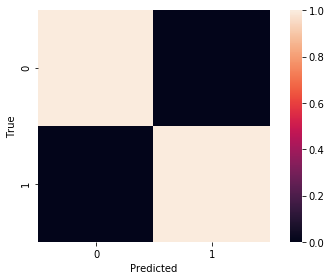

In [8]:
clf = _cv(X, y, 10, 'name', LogisticRegression(solver='lbfgs'), 'foo.csv', modeldir='../work', terms=terms, resultdir='../work')

In [9]:
clf.classes_

array([0, 1])

In [10]:
clf.coef_[0]

array([ 2.24482262,  2.24424061, -2.14186277, -2.13967196, -2.1405273 ,
        2.24523331, -2.13965475, -2.13854639, -2.13845327, -2.1407568 ,
       -2.14462209,  2.24613296,  2.24276795,  0.10771154,  2.24801507,
        2.2431061 ])

In [11]:
terms

array(['ntcreateprocessex', 'ntcreatethreadex', 'ntcreateuserprocess',
       'ntdisplaystring', 'ntdrawtext', 'ntmodifybootentry', 'ntopenfile',
       'ntopenkeyex', 'ntopentimer', 'ntquerydirectoryfile', 'ntreadfile',
       'ntsavekeyex', 'ntsettimerex', 'ntwritefile', 'regcreatekeyex',
       'regsavekeyex'],
      dtype='<U20')

# It's dangerous to go alone! Take this.

In [12]:
def get_feature_vector(path, vectorizer):
    """get_feature_vector returns a vectorized feature vector (using `vectorizer`) for the system call trace in `path`,
    e.g., try get_feature_vector('../data/01-monotonic-classifiers/malicious-traces/0999.trace', vectorizer)
    """
    with open(path) as f:
        return vectorizer.transform([f.read()])

# Direct Attack

You (somehow) have direct access to the feature vectors. Don't ask how, celebrate! Traces are stored in `../data/01-monotonic-classifiers/{malicious,benign}-traces/`. I recommend writing a functions that returns a feature vector given the path of a trace, comparing benign and malicious vectors, and manually transforming a malicious vector to a benign vector. If you have time, write a function to perform this manipulation.

## Indirect Attack Part 1 (Find terms)

So we've made our malware undetectable (above), but we did so by directly manipulating the feature vector. This assumes a powerful and/or dedicated attacker and we're a bit lazy. How can we alter our malware's _behavior_ such that our malware is classified as benign software? Let's identify `terms` that are more likely to be associated with benign software than malicious software by finding _negative_ coefficients in the model.

## Indirect Attack Part 2 (Adversarial Sample Generation)

## Make Classifier Monotonic

A simple way to make a classifier monotonic for our purposes is to not allow attackers to abuse negative coefficient features. Add a vector to `clf.coef` such that there are no longer negative coefficients, and demonstrates this defeats your adversarial generation function from the previous exercise.

We can accomplish this by:
* Identify the index in `clf.coef_` for the feature you abused
* Set its weight to `0.0`
* Rerunning our classification examples from above